In [ ]:
"""
Project Overview:

This project includes multiple models to predict a stock's price and analyze potential investment opportunities:
1. **Linear Models (Ridge, Lasso, ElasticNet)**: Regularization techniques used to prevent overfitting, optimized with RandomizedSearchCV.
    - Optimised regression methods such as ridge or lasso used over linear regression for better performance through a better cost function.
2. **Ensemble Models (Random Forest, Gradient Boosting, CatBoost)**: Capture non-linear relationships and interactions, use early stopping for regularization.
    - **CatBoost**: Unique model but used as it handles categorical data natively, requires less hyperparameter tuning, and is efficient with high performance on large datasets.
3. **LSTM**: Recurrent neural network for time series forecasting, incorporates dropout and early stopping.
4. **Monte Carlo Simulation**: Provides probabilistic future stock price ranges, including mean, median, and confidence intervals.
5. **Ichimoku Cloud**: Technical indicator for trend analysis, visualizes support and resistance levels.
6. **NLP on 10-K Statements**: Sentiment analysis using VADER on 10-K filings of Dow Jones companies.

Optimizations include regularization, hyperparameter tuning, feature engineering, and advanced visualizations. The results help in predicting stock prices, understanding market trends, and making informed investment decisions.
This code uses AAPL, but any stock can be used.
"""

"\nProject Overview:\n\nThis project includes multiple models to predict a stock's price and analyze potential investment opportunities:\n1. **Linear Models (Ridge, Lasso, ElasticNet)**: Regularization techniques used to prevent overfitting, optimized with RandomizedSearchCV. \n    - Optimised regression methods such as ridge or lasso used over linear regression for better performance through a better cost function.\n2. **Ensemble Models (Random Forest, Gradient Boosting, CatBoost)**: Capture non-linear relationships and interactions, use early stopping for regularization.\n    - **CatBoost**: Unique model but used as it handles categorical data natively, requires less hyperparameter tuning, and is efficient with high performance on large datasets.\n3. **LSTM**: Recurrent neural network for time series forecasting, incorporates dropout and early stopping.\n4. **Monte Carlo Simulation**: Provides probabilistic future stock price ranges, including mean, median, and confidence intervals.\

In [ ]:
!pip install yfinance pandas numpy matplotlib tensorflow nltk sec-edgar-downloader catboost ta

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.stats import uniform
import ta

In [ ]:
# Fetch data from Yahoo Finance
start_date = "2020-01-01"
end_date = datetime.now().strftime('%Y-%m-%d')
df = yf.download('AAPL', start=start_date, end=end_date)

# Feature Engineering
df['MA10'] = df['Adj Close'].rolling(window=10).mean()
df['MA20'] = df['Adj Close'].rolling(window=20).mean()
df['MA50'] = df['Adj Close'].rolling(window=50).mean()
df['EMA10'] = df['Adj Close'].ewm(span=10, adjust=False).mean()
df['EMA20'] = df['Adj Close'].ewm(span=20, adjust=False).mean()
df['EMA50'] = df['Adj Close'].ewm(span=50, adjust=False).mean()
df['RSI'] = ta.momentum.rsi(df['Adj Close'], window=14)
df['MACD'] = ta.trend.macd_diff(df['Adj Close'])
df['High_Low_Diff'] = df['High'] - df['Low']
df['Open_Close_Diff'] = df['Open'] - df['Close']

# Create lagged features
for lag in range(1, 6):
    df[f'Lag_{lag}'] = df['Adj Close'].shift(lag)

# Drop NaN values
df = df.dropna()

# Prepare the data
features = ['MA10', 'MA20', 'MA50', 'EMA10', 'EMA20', 'EMA50', 'RSI', 'MACD', 'High_Low_Diff', 'Open_Close_Diff'] + [f'Lag_{lag}' for lag in range(1, 6)]
X = df[features]
y = df['Adj Close']

# Create interaction terms
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_interactions = poly.fit_transform(X)

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_interactions)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

[*********************100%%**********************]  1 of 1 completed


Ridge Test RMSE: 0.9653595330882101
Lasso Test RMSE: 4.675956649362748
ElasticNet Test RMSE: 5.225345700594457


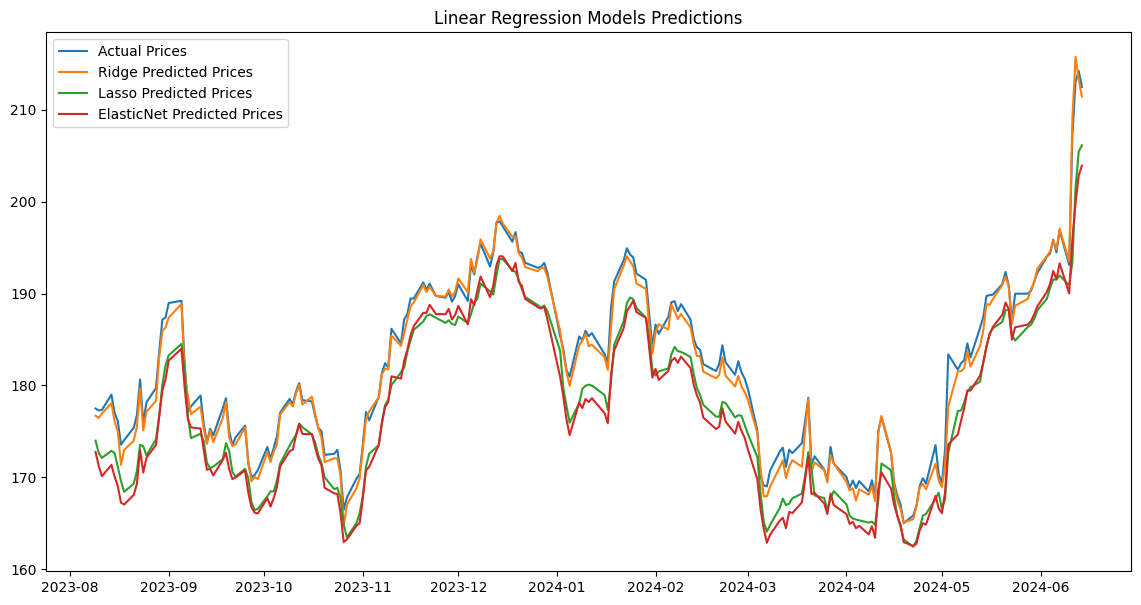

In [ ]:
### Linear Regression Models ###

# Ridge Regression with RandomizedSearchCV
ridge = Ridge()
ridge_params = {'alpha': uniform(0.1, 100)}
ridge_search = RandomizedSearchCV(ridge, ridge_params, n_iter=20, cv=5, random_state=42)
ridge_search.fit(X_train, y_train)
ridge_best = ridge_search.best_estimator_

# Lasso Regression with RandomizedSearchCV
lasso = Lasso(max_iter=5000)
lasso_params = {'alpha': uniform(0.1, 100)}
lasso_search = RandomizedSearchCV(lasso, lasso_params, n_iter=20, cv=5, random_state=42)
lasso_search.fit(X_train, y_train)
lasso_best = lasso_search.best_estimator_

# ElasticNet with RandomizedSearchCV
elasticnet = ElasticNet(max_iter=5000)
elasticnet_params = {'alpha': uniform(0.1, 100), 'l1_ratio': uniform(0.1, 0.9)}
elasticnet_search = RandomizedSearchCV(elasticnet, elasticnet_params, n_iter=20, cv=5, random_state=42)
elasticnet_search.fit(X_train, y_train)
elasticnet_best = elasticnet_search.best_estimator_

# Predictions on test set
ridge_test_predictions = ridge_best.predict(X_test)
lasso_test_predictions = lasso_best.predict(X_test)
elasticnet_test_predictions = elasticnet_best.predict(X_test)

# Evaluate Linear Models
ridge_test_rmse = np.sqrt(mean_squared_error(y_test, ridge_test_predictions))
lasso_test_rmse = np.sqrt(mean_squared_error(y_test, lasso_test_predictions))
elasticnet_test_rmse = np.sqrt(mean_squared_error(y_test, elasticnet_test_predictions))

print(f'Ridge Test RMSE: {ridge_test_rmse}')
print(f'Lasso Test RMSE: {lasso_test_rmse}')
print(f'ElasticNet Test RMSE: {elasticnet_test_rmse}')

# Plot Linear Regression Predictions
plt.figure(figsize=(14,7))
plt.plot(df.index[-len(y_test):], y_test, label='Actual Prices')
plt.plot(df.index[-len(y_test):], ridge_test_predictions, label='Ridge Predicted Prices')
plt.plot(df.index[-len(y_test):], lasso_test_predictions, label='Lasso Predicted Prices')
plt.plot(df.index[-len(y_test):], elasticnet_test_predictions, label='ElasticNet Predicted Prices')
plt.legend()
plt.title('Linear Regression Models Predictions')
plt.show()

In [ ]:
### Tree-based Models ###

# Random Forest with RandomizedSearchCV
rf = RandomForestRegressor()
rf_params = {'n_estimators': [50, 100], 'max_features': ['sqrt'], 'max_depth': [5, 10]}
rf_search = RandomizedSearchCV(rf, rf_params, n_iter=20, cv=5, random_state=42)
rf_search.fit(X_train, y_train)
rf_best = rf_search.best_estimator_

# Gradient Boosting with RandomizedSearchCV and early stopping
gbr = GradientBoostingRegressor()
gbr_params = {'n_estimators': [100, 200], 'learning_rate': uniform(0.01, 0.1), 'max_depth': [3, 5]}
gbr_search = RandomizedSearchCV(gbr, gbr_params, n_iter=20, cv=5, random_state=42)
gbr_search.fit(X_train, y_train)
gbr_best = gbr_search.best_estimator_

# CatBoost with RandomizedSearchCV and early stopping
catboost = CatBoostRegressor(verbose=0)
catboost_params = {'iterations': [500, 1000], 'learning_rate': uniform(0.01, 0.1), 'depth': [4, 6], 'early_stopping_rounds': [50]}
catboost_search = RandomizedSearchCV(catboost, catboost_params, n_iter=20, cv=5, random_state=42)
catboost_search.fit(X_train, y_train, eval_set=(X_test, y_test))
catboost_best = catboost_search.best_estimator_

# Predictions on test set
rf_test_predictions = rf_best.predict(X_test)
gbr_test_predictions = gbr_best.predict(X_test)
catboost_test_predictions = catboost_best.predict(X_test)

# Evaluate Tree-based Models
rf_test_rmse = np.sqrt(mean_squared_error(y_test, rf_test_predictions))
gbr_test_rmse = np.sqrt(mean_squared_error(y_test, gbr_test_predictions))
catboost_test_rmse = np.sqrt(mean_squared_error(y_test, catboost_test_predictions))

print(f'Random Forest Test RMSE: {rf_test_rmse}')
print(f'Gradient Boosting Test RMSE: {gbr_test_rmse}')
print(f'CatBoost Test RMSE: {catboost_test_rmse}')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=20. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
### LSTM Model ###

# Prepare data for LSTM
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Adj Close', 'RSI', 'MACD', 'High_Low_Diff', 'Open_Close_Diff']])
sequence_length = 60
X, y = [], []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Predictions on test set
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], 4))), axis=1))[:,0]

# Evaluate LSTM Model
lstm_test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'LSTM Test RMSE: {lstm_test_rmse}')

# Plot LSTM predictions
plt.figure(figsize=(14,7))
plt.plot(df.index[-len(y_test):], df['Adj Close'].iloc[-len(y_test):], label='Actual Prices')
plt.plot(df.index[-len(y_test):], test_predict, label='LSTM Predicted Prices')
plt.legend()
plt.show()

Epoch 1/100


KeyboardInterrupt: 

In [ ]:
from sec_edgar_downloader import Downloader

# Initialize the downloader with your email address and a company name
dl = Downloader(email_address="kinghursh.shah@gmail.com", company_name="YourCompanyName")

# Dow Jones Industrial Average companies tickers
dow_jones_stocks = [
    'AAPL', 'MSFT', 'JPM', 'V', 'JNJ', 'WMT', 'PG', 'DIS', 'UNH', 'HD',
    'VZ', 'INTC', 'MRK', 'PFE', 'KO', 'BA', 'CSCO', 'XOM', 'MCD', 'IBM',
    'GS', 'AXP', 'CAT', 'NKE', 'TRV', 'MMM', 'WBA', 'DOW', 'CRM', 'AMGN'
]

# Download 10-K statements for each company
for stock in dow_jones_stocks:
    dl.get("10-K", stock)

print("Downloaded 10-K statements for all companies.")


In [ ]:
# Sentiment Analysis on 10-K Statements
sid = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    return sid.polarity_scores(text)

# Path to the directory where 10-K statements are saved
base_dir = "sec-edgar-filings"

# Collect sentiment scores
sentiments = {}

for stock in dow_jones_stocks:
    stock_dir = os.path.join(base_dir, stock)
    if os.path.exists(stock_dir):
        for root, dirs, files in os.walk(stock_dir):
            for file in files:
                if file.endswith(".txt"):
                    file_path = os.path.join(root, file)
                    print(f"Reading file: {file_path}")
                    with open(file_path, 'r', encoding='utf-8') as f:
                        text = f.read()
                        sentiments[stock] = analyze_sentiment(text)
                        print(f"Sentiment for {stock}: {sentiments[stock]}")

# Display the sentiment scores
print("\nSentiment Scores:")
for stock, sentiment in sentiments.items():
    print(f"Sentiment for {stock}: {sentiment}")

Monte Carlo Simulation Results after 252 days:
Mean Price: 304.29
Median Price: 290.72
95% Confidence Interval: [172.27, 473.93]


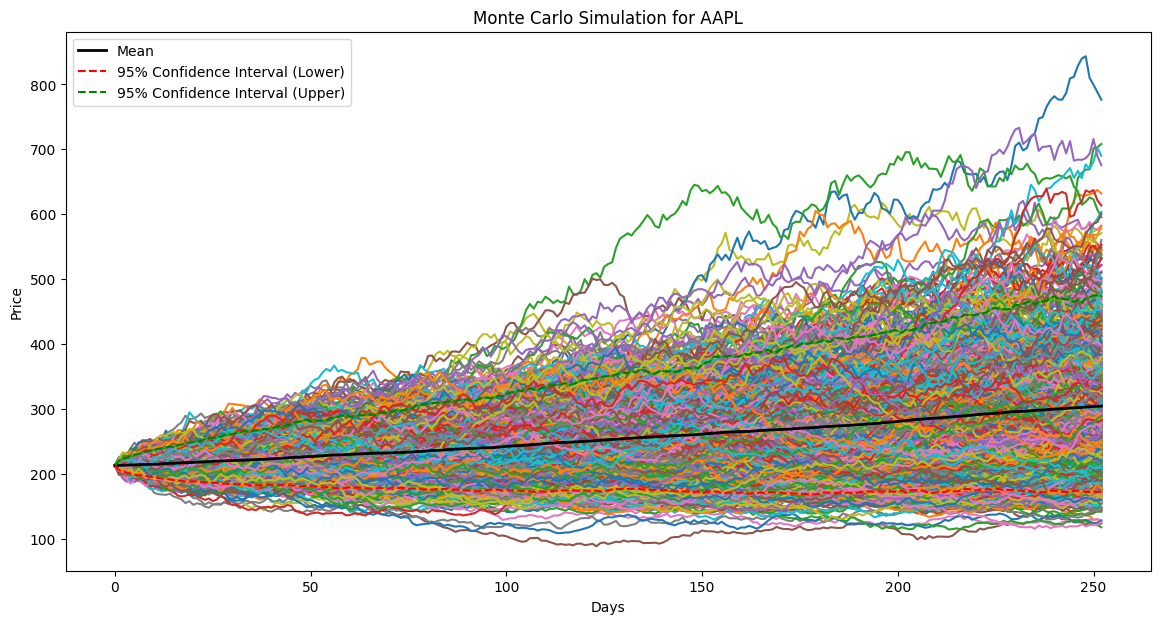

In [ ]:
### Monte Carlo Simulation ###

def monte_carlo_simulation(start_price, days, mu, sigma, n_simulations=1000):
    simulations = []
    for _ in range(n_simulations):
        prices = [start_price]
        for _ in range(days):
            prices.append(prices[-1] * np.exp(np.random.normal(mu, sigma)))
        simulations.append(prices)
    return simulations

# Parameters
mu = df['Adj Close'].pct_change().mean()
sigma = df['Adj Close'].pct_change().std()
start_price = df['Adj Close'].iloc[-1]

# Run Simulation
n_days = 252
simulations = monte_carlo_simulation(start_price, n_days, mu, sigma)

# Convert to DataFrame
simulations_df = pd.DataFrame(simulations).T
simulations_df['mean'] = simulations_df.mean(axis=1)
simulations_df['lower'] = simulations_df.quantile(0.05, axis=1)
simulations_df['upper'] = simulations_df.quantile(0.95, axis=1)

# Print Summary Statistics
end_prices = simulations_df.iloc[-1, :-3]
mean_price = end_prices.mean()
median_price = end_prices.median()
lower_95 = end_prices.quantile(0.05)
upper_95 = end_prices.quantile(0.95)

print(f"Monte Carlo Simulation Results after {n_days} days:")
print(f"Mean Price: {mean_price:.2f}")
print(f"Median Price: {median_price:.2f}")
print(f"95% Confidence Interval: [{lower_95:.2f}, {upper_95:.2f}]")

# Plot Simulation
plt.figure(figsize=(14,7))
plt.plot(simulations_df)
plt.plot(simulations_df['mean'], label='Mean', color='black', linewidth=2)
plt.plot(simulations_df['lower'], label='95% Confidence Interval (Lower)', color='red', linestyle='--')
plt.plot(simulations_df['upper'], label='95% Confidence Interval (Upper)', color='green', linestyle='--')
plt.xlabel('Days')
plt.ylabel('Price')
plt.title(f"Monte Carlo Simulation for AAPL")
plt.legend()
plt.show()

<ipython-input-9-56ae06f2cf1e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tenkan_sen'] = (df['High'].rolling(window=9).max() + df['Low'].rolling(window=9).min()) / 2
<ipython-input-9-56ae06f2cf1e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['kijun_sen'] = (df['High'].rolling(window=26).max() + df['Low'].rolling(window=26).min()) / 2
<ipython-input-9-56ae06f2cf1e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

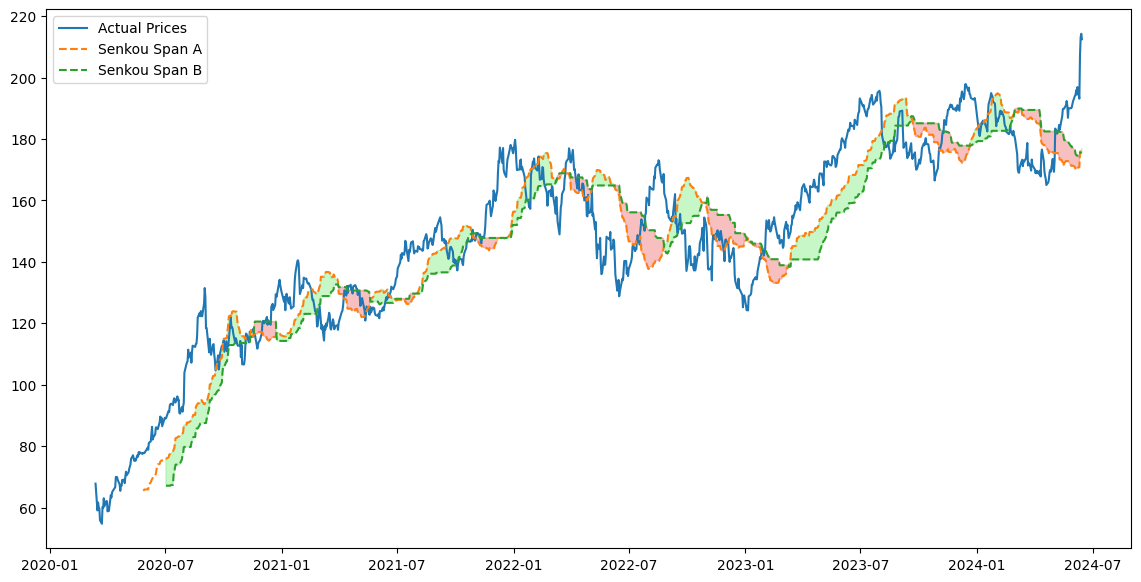

In [ ]:
### Ichimoku Cloud ###

df['tenkan_sen'] = (df['High'].rolling(window=9).max() + df['Low'].rolling(window=9).min()) / 2
df['kijun_sen'] = (df['High'].rolling(window=26).max() + df['Low'].rolling(window=26).min()) / 2
df['senkou_span_a'] = ((df['tenkan_sen'] + df['kijun_sen']) / 2).shift(26)
df['senkou_span_b'] = ((df['High'].rolling(window=52).max() + df['Low'].rolling(window=52).min()) / 2).shift(26)
df['chikou_span'] = df['Adj Close'].shift(-26)

plt.figure(figsize=(14,7))
plt.plot(df.index, df['Adj Close'], label='Actual Prices')
plt.plot(df.index, df['senkou_span_a'], label='Senkou Span A', linestyle='--')
plt.plot(df.index, df['senkou_span_b'], label='Senkou Span B', linestyle='--')
plt.fill_between(df.index, df['senkou_span_a'], df['senkou_span_b'], where=(df['senkou_span_a'] > df['senkou_span_b']), color='lightgreen', alpha=0.5)
plt.fill_between(df.index, df['senkou_span_a'], df['senkou_span_b'], where=(df['senkou_span_a'] <= df['senkou_span_b']), color='lightcoral', alpha=0.5)
plt.legend()
plt.show()